# Introduction: the Automated TA 

Suppose that you are a TA for a calculus class, and the professor wants you to grade the homeworks and exams. But seeing that you are quite busy with research, and less interested in grading exams, you wish to train a neural network to do the grading for you. Fortunately, your professor happens to have a dataset of 8000 different images of different math symbols related to calculus (described in detail below). Now, your goal is to convince your professor to trust your network, and free you from hours of painstaking grading. 

# Data Explanation 

The full dataset for training and validation consists of 8,000 different handwritten images of math symbols, related to portions of calculus problems. There are 16 different classes (detailed below). The size of these images are (64 x 64) pixels. Seeing that the images were already clean, I didn't process them further. 

**Categories to predict** 

|Categroies|Math Symbol|
|-----|-----------|
| 0   |  $x$      |
| 1   |$x^2$| 
| 2   |$x^3$|
| 3   |$x^4$|
| 4   |$2x$ |
| 5   |$3x^2$|
| 6   |$4x^3$|
| 7   |$x^2/2$|
| 8   |$\frac{1}{3} x^3$|
| 9   |$\frac{1}{4} x^4$|
| 10  |$\frac{1}{5} x^5$|
| 11  |$+ C$|
| 12  |$\frac{1}{2} t^2$|
| 13  |$\frac{1}{3} t^3$|
| 14  |$\frac{1}{4} t^4$|
| 15  |$\frac{1}{5} t^5$|

The last few classes exchange $x$ for $t$ (because this opens the door to story problems involving time). From our understanding of calculus, it should be apparent how the above classes are related to various components of simple calculus problems involving derivatives or integrals. Accepting $t$ and $x$ as answer variables is accounted for by the grading portion, after the neural network has identified the symbols of a specific answer. A sample from the training set for all of the categories is shown below. 

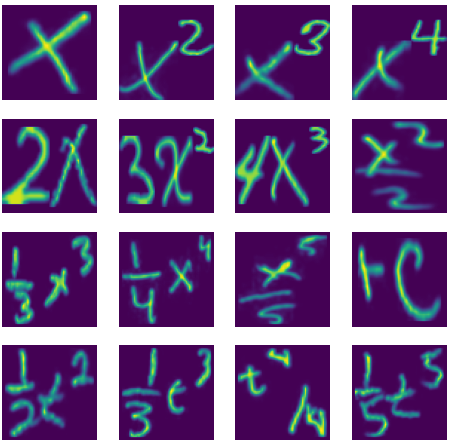

To highlight a challenge with this particular dataset, for the classes that involve fractions, there are multiple *correct* ways for a student to represent their answer. For example, the following notations are equivalent: 

$\frac{1}{3} t^3 = \frac{t^3}{3}$ 

Our neural network will have to correctly identify both of these notations. This difference shows up in the data too as shown by the following samples from the training set: 

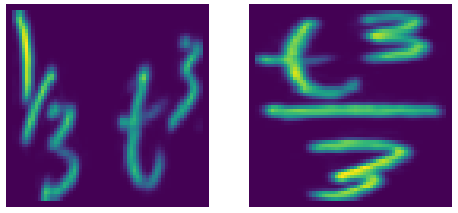

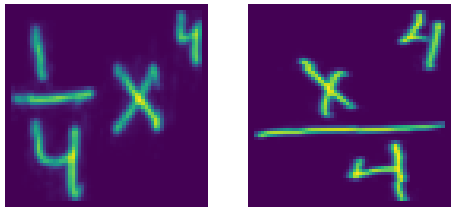

## Machine Learning Approach 

As with most image classification problems, using a deep convolutional neural network is designed to process the images and classify them into one of the categories mentioned above. For this case, I used a convolutional neural network with the following parameters: 

9 2D convolutional layers, 8 batchnorm layers, 3 dropout layers, and 1 linear layer organized with batchnorm layers following the 2D convolutional layers. Dropout layers were added intermittently, and finished with a linear layer. Average pooling was used following the convolutional layers, while the relu activation function was used following the batchnorm layers. The total model has 290,036 trainable parameters. 

Again keeping consistency with classification problems, I trained this network using the CrossEntropy loss function, and updated the network parameters using the RMSProp optimizer. Some insights that I had gained from previous network training: 

* Average pooling led to higher accuracy than Maxpooling (98% vs 94%)
* Dropout and batchnormalization improved the model accuracy, presumably necessary for the network to approach 98% accuracy 

In [ ]:
# Import the required packages, using PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import time
import math
from torch.nn.parameter import Parameter
from torchsummary import summary

# Develop neural network 
class light_net(nn.Module):
    def __init__(self):
        super(light_net,self).__init__()
        self.conv0=nn.Conv2d(1,20,10,stride=2)
        self.convs1 = nn.Sequential(nn.Conv2d(20,64,2,stride=1), nn.Conv2d(64,64,2,stride=1))
        self.bns1 = nn.Sequential(nn.BatchNorm2d(64),nn.BatchNorm2d(64))
        self.dropout1 = nn.Dropout(0.2)
        
        self.convs2 = nn.Sequential(nn.Conv2d(64,64,2,stride=1), nn.Conv2d(64,64,2,stride=1), nn.Conv2d(64,128,2,stride=1)) 
        self.bns2 = nn.Sequential(nn.BatchNorm2d(64),nn.BatchNorm2d(64),nn.BatchNorm2d(128))
        self.dropout2 = nn.Dropout(0.3)   
        
        self.convs3 = nn.Sequential(nn.Conv2d(128,128,2,stride=1), nn.Conv2d(128,128,2,stride=1), nn.Conv2d(128,128,2,stride=1))  
        self.bns3 = nn.Sequential(nn.BatchNorm2d(128),nn.BatchNorm2d(128),nn.BatchNorm2d(128))
        self.dropout3 = nn.Dropout(0.4)
        
        self.last = nn.Linear(128,16)

    # Defining a pass through the network 
    def forward(self, input):
        x = F.relu(self.conv0(input))
        for bn, conv in zip(self.bns1, self.convs1):
            x = F.relu(bn(conv(x)))
        #x = F.max_pool2d(x,2) --> did NOT help accuracy 
        x = F.avg_pool2d(x,2)
        x = self.dropout1(x)
        
        for bn, conv in zip(self.bns2, self.convs2):
            x = F.relu(bn(conv(x)))
        x = F.avg_pool2d(x,2)
        x = self.dropout2(x)

        for bn, conv in zip(self.bns3, self.convs3):
            x = F.relu(bn(conv(x)))
        x = F.avg_pool2d(x,2)
        x = self.dropout3(x)
        x = x.reshape(x.size(0),-1)
        
        x = self.last(x)
        return x

In [ ]:
# Loading the dataset 
X = np.load('...')
y = np.load('...')
X=np.array(X).reshape((-1,1,64,64)) # reshape from 64x64 to 1x64x64
y=np.array(y).reshape((-1,))

class get_data(Dataset):
    def __init__(self, data,label):
        self.data = torch.FloatTensor(data.astype('float'))
        self.label = torch.from_numpy(label).long()
        
    def __len__(self):
        return self.label.shape[0]
    
    def __getitem__(self, index):
        data_val = self.data[index]
        target = self.label[index]
        return data_val,target

# Shuffle the dataset 
I=np.arange(8000)    
np.random.shuffle(I)
    
# Split the training set 
trainset = get_data(X[I[:6000]], y[I[:6000]])
trainloader = DataLoader(trainset, batch_size=60, shuffle=True, num_workers=0)

# Split the validation set
testset = get_data(X[I[6000:]], y[I[6000:]])
testloader = DataLoader(testset, batch_size=60, shuffle=False, num_workers=0)

# Enable gpu, if available 
net=light_net()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device=='cuda':
    net = net.cuda()
    print('using gpu')

# Loss function for training 
criterion=nn.CrossEntropyLoss()

In [ ]:
# Optimizer for machine learning 
optimizer = optim.RMSprop(net.parameters(),lr=0.0001)

# Training epochs 
epochs = 10

# Training loop 
for epoch in range(epochs):
    
    # Train the model and print the training accuracy 
    net.train() 
    correct=0
    total=0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() 
    print("Epoch ", epoch+1, 'Train_accuaray:', 100.*correct/total)

    # Assess the model's accuracy on the with-held validation set 
    net.eval()
    correct=0
    total=0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() 
    print('       Test_accuaray:', 100.*correct/total)

# Testing 

Correctly identifying one math symbol, is just one part of the puzzle. The second part involves analyzing a student's answer, which introduces more complexity. In particular, the size of the image increases from $[64 x 64]$ to $[64 x 384]$. To comply with the trained network's architecture, I chose to simplify the processing of a student's answer by cutting the answer into several slices, and classifying the most important slices. Using the network's classifications, I then computed the student's score for the problem on a scale of 0-10. Since the professor is generous and gives partial credit for partially correct answers, I interfaced the network output to be consistent with these grading rules. 

In [ ]:
# A lazy way of slicing out the symbols: Assume they are of the same size. 
# Then only three of the six symbols are relavant, mainly, the second, the fifth and the last
# Better results can be obtained if I segment the symbols more carefully.
First=Problems[:,:,64:128]
Second=Problems[:,:,4*64:5*64]
Third=Problems[:,:,5*64:]
# predict the cut-off symbols using the trained model
First=np.reshape(First,(-1,64*64))
Second=np.reshape(Second,(-1,64*64))
First=np.reshape(First,(-1,1,64,64))
Second=np.reshape(Second,(-1,1,64,64))

# use the network to identify the student's handwritten solution 
pred_First=np.zeros(First.shape[0])
pred_Second=np.zeros(Second.shape[0])
for i in range(100):
    syms=torch.FloatTensor(First[i*200:(i+1)*200].astype('float')).to(device)
    T=net(syms).detach().cpu().numpy()
    
    pred_First[i*200:(i+1)*200]=np.argmax(T,1)
    syms=torch.FloatTensor(Second[i*200:(i+1)*200].astype('float')).to(device)
    T=net(syms).detach().cpu().numpy()
    pred_Second[i*200:(i+1)*200]=np.argmax(T,1)
    
# Using the grading rules, and the network predictions, calculate a student's score 
# the network gives partial credit for the student's scores
# thus leading to a more complex solution 
A=(pred_First<4)
B=(pred_First<7)*(pred_First>3)
C=(pred_First>0)*A
D7=(pred_Second-pred_First==7)
D3=(pred_Second-pred_First==3)
D12=(pred_Second-pred_First==12)
D_3=(pred_Second-pred_First==-3)
Score=(A*D7*10+B*D_3*10+A*D12*5+C*D3*2)*(np.mean(np.mean(Third[:,:,10:64],-1),-1)>0.03)
Score += (A*D7*9+B*D_3*9+A*D12*5+C*D3*1)*(np.mean(np.mean(Third[:,:,10:64],-1),-1)<0.03)

# Save the score as my_submission, which can be uploaded for the submission.
print('Done! The first 10 problems have predicted scores:', Score[:10])

# Conclusions and Future Directions 

While I managed to place in the top 10, there are alternative approaches to investigate that may lead to better network performance: 

* Trying some image pre-processing techniques, such as whitening may have helped the network learn features better 
* Not manually slicing the data, and instead getting the network to segment the math problems could've led to better performance 
* Using a ResNet structure may have helped, but was not tested here 

In this particular case, we have focused on a subset of potential calculus problems. Scaling this approach to classify more written mathematical symbols not included in the dataset would be interesting and would likely require a larger network to be used. Nonetheless, this serves as a great example of a proof of concept where a network can grade simple homework problems for students. 